In [68]:
import pandas as pd
import glob 
import numpy as np
import seaborn as sns
from util.DataLoaders import FileDataLoader
from util.Predictors import Model, report_to_df

**Question 1**

Did the personalised marketing campaign change the amount of money spent? Please show us
what kind of statistical analysis you would do if asked to evaluate an experiment like this

Our hypothesis is that the personalised marketing campaign changed the amount of money spent. In order to measure the impact on money spent we can use the variable 'spent_18' which records the amount of money spent by each user last year. Using total money spent may not be optimal, as the actual number of users who effectively received the marketing campaign might vary by chance (see later question). Thus, a good metric that we can use to measure the impact of change is money-spent-per-user. Another Metric that we could use is the y.o.y. increase in money-spent-per-user.  

In [69]:
df = pd.read_csv('..\data\dataset_experimentation.csv')
df = df.drop_duplicates()

In [70]:
df.test.value_counts()

0    6413
1    2186
Name: test, dtype: int64

Below, We quantitatively test whether the observed difference of changes in money-spent-per-user between the Treatment and Control samples is unlikely, given the Null hypothesis that the two means come from the same popoulations (or, the two means are equal and their difference is 0).

In [71]:
#observed difference in money-spent-per-user between the Treatment and Control samples 
spent_18_c = df[df.test == 0].spent_18.values #money spent 2018 - control group
spent_18_t = df[df.test == 1].spent_18.values #money spent 2018 - treatment group
spent_18_t.mean()  - spent_18_c.mean()

2.172752716218511

In [72]:
from scipy import stats

#the metrics have unequal variance 
if spent_18_t.std() != spent_18_c.std(): equal_var = False

#how likely is this difference, given the Null that the means are equal?
stats.ttest_ind(spent_18_t, spent_18_c, equal_var = equal_var)

Ttest_indResult(statistic=4.139045527828852, pvalue=3.5607427992031165e-05)

**Question 2**

Is there something you would check about how the experiment has been set up? How?

1) The problem statements suggests that the experiment was a pretty standard randomized trial, where first *a population was defined*. I would be interested in checking how this population was defined. For example, Was the experiment designed to examine a specific geographical, demographic or socioeconomic segment? This is important as selecting a specific segment would change our power to detect the impact of the campaign. 

2) How long was the campaign? The longer the experiment, more users we should expect the campaign to be targeted to. More importantly, we only have revenue per year. For the results to hold, we need the marketing campaign to target users during the entire year, otherwise we may capture the effect of other varaibles. For example, if the campaign was run in a Holiday period, we may easily capture the effect of Holidays, which is not what we are loking for.

**Question 3** 

Can you think of (a) different way(s) to leverage any suitable pre-experiment data for this test? If so, how are the results affected?

The metric that we use, moeny-spent-per-user can naturally vary quite a lot. We can use pre-experiment data to control for this natural variation in our metric. CUEPED is a standard technique to do so. 

Money-Spent-per-user at time $t$ is probably correlated to previous Money-Spent-per-user at time $t-1$. We can check that using our Data.

In [73]:
#correlation between Money spent in 2018 and Money spent in 2017
from scipy import stats
stats.pearsonr(df.spent_18, df.spent_17)

(0.8056982508003442, 0.0)

In [74]:
np.cov(df.spent_17.values, df.spent_18.values)

array([[472.61142373, 379.51202949],
       [379.51202949, 469.46372052]])

In [75]:
#calculate the CUEPED adjusted metric
spent_17_c = df[df.test == 0].spent_17.values #money spent 2017 - control group
spent_17_t = df[df.test == 1].spent_17.values #money spent 2017 - treatment group

theta_c = np.cov(spent_17_c, spent_18_c)[0, 1] / np.cov(spent_17_c)
theta_t = np.cov(spent_17_t, spent_18_t)[0, 1]  / np.cov(spent_17_t)

spent_18_c_adj = spent_18_c - theta_c * (spent_17_c - spent_17_c.mean())
spent_18_t_adj = spent_18_t - theta_t * (spent_17_t - spent_17_t.mean())

print(spent_18_c.mean(), spent_18_c_adj.mean(), spent_18_t.mean(), spent_18_t_adj.mean())
print(spent_18_c.std(), spent_18_c_adj.std(), spent_18_t.std(), spent_18_t_adj.std())

66.48548991865542 66.48548991865543 68.65824263487393 68.65824263487393
21.87615690104296 12.80655481804166 20.9529101109173 12.769118992708089


As we can see, we reduced our metrics standard deviation by quite a lot.

In [76]:
#repeating the same analysis, we confirm that we increase statistical power

#the metrics have unequal variance 
if spent_18_t_adj.std() != spent_18_c_adj.std(): equal_var = False
  
stats.ttest_ind(spent_18_t_adj, spent_18_c_adj, equal_var = equal_var)

Ttest_indResult(statistic=6.863956835097949, pvalue=7.792886913920218e-12)

**Question 4**

Our personalisation experts suggested there might be subgroups among the customers for which the experiment worked better than for the rest. What kind of statistical analysis / causal modelling would you do to investigate this possibility?

Different effects across groups are definitely a possibility, especially if the population on which we ran the experiment was not segmented (see question 2) and all users (or average type of users) were targeted by the marketing campaign. For example, it may be supposed that the campaign worked differently, and had a different impact, for different users device. Then, we would have to compare the effect of the marketing campaign on money spent based on the type of device (tablet, pc, laptop, smartphone) used. Many other possible segmentations are available. 

One possible solution is to test if interactions are significant in the following logistic regression model: 

$moneyspent18 = \beta_1 device type * treatment group$

If the coefficient related to the interaction term is significant, we can conclude that the effect of the treatment varies between users with different device types.

**Question 5**

Did the campaign affect how many users reported a great customer experience?

In [77]:
#observed difference of changes in money-spent-per-user between the Treatment and Control samples 
gcc_18_c = df[df.test == 0].great_customer_class.values #money spent 2018 - control group
gcc_18_t = df[df.test == 1].great_customer_class.values #money spent 2018 - treatment group
gcc_18_t.mean()  - gcc_18_c.mean()

-0.009154124120878099

In [78]:
#how likely is this difference, given the Null that the means are equal?
from scipy import stats

#the metrics have unequal variance 
if gcc_18_t.std() != gcc_18_c.std(): equal_var = False

stats.ttest_ind(gcc_18_t, gcc_18_c)

Ttest_indResult(statistic=-1.0787735744503235, pvalue=0.2807189435702946)

We cannot conclude that the campaign affected how many users reported a gret customer experience

**Question 6**

You learn that only about a third of all personalised messages were actually sent, but we don’t know which users received them. All sent messages were read, though. Does this change what you think about the impact of the personalised messages on spending?

Yes, it does. We can leverage simulations of the experiments in which only a third of the users in the treatment group are considered, and the others are left in the control group. In order to understand the impact of the personalised messages, my strategy is the following:
1. Randomly select a third of the users in the treatment group 
2. Exclude these users from the treatment group and insert them in the control group
3. compute the p-value associated with a t-test, comparing spending means of the two newly created groups

We can repeat the above steps many times and plot a distribution of the p-values to get an expected value. 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.52it/s]


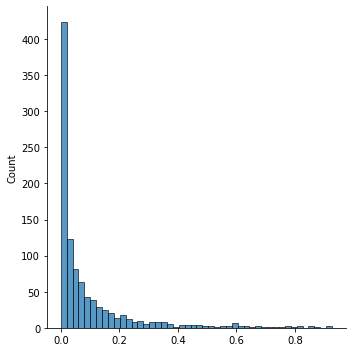

In [79]:
from tqdm import tqdm
n = 1000

p_values = []
for _ in tqdm(range(n)):
    df_simulation = df.copy()
    sent_idxs = df_simulation[df_simulation.test == 1].sample(frac = 1/3).index.tolist() #indexes of the users who received the message
    not_sent_idxs = [x for x in df_simulation.index.tolist() if x not in sent_idxs] #indexes of users who did not receive the message
    assert len(sent_idxs + not_sent_idxs) == len(df_simulation)
    df_simulation.loc[not_sent_idxs, 'test'] = 0 #assign the rest of the users to control group
    
    #observed difference in money-spent-per-user between the Treatment and Control samples 
    spent_18_c = df_simulation[df_simulation.test == 0].spent_18.values #money spent 2018 - control group
    spent_18_t = df_simulation[df_simulation.test == 1].spent_18.values #money spent 2018 - treatment group
    p_values.append(stats.ttest_ind(spent_18_t, spent_18_c, equal_var = False)[1])
    
sns.displot(p_values)

In [80]:
np.mean(p_values)

0.09267778262559853

With an alpha value of 0.05, On average, we would not reject the Null Hypothesis that the the two means come from the same popoulations, and that the campaign did not have an effect on money spent. Hence, the new information definitely changes what we think about the impact of the personalised messages on spending.